# Project 3: Doping at the Olympics

Doping was banned in 1967 and testing started in 1968. A doping instance is where a team member was caught violating anti-doping rules and action was taken. Team members were primarily athletes but some were not (e.g. Dr. Otto Trefny as medical staff in 1976 Innsbruck). Action was primarily disqualification/banning during or after performance in the games or did not start status prior to the games. Team members caught without action taken are not counted (e.g. East Germany).

## Setup

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Doping

Count the number of doping instances from each country in the Summer Olympic Games and the Winter Olympic Games. Counts come from iterating over tables and table rows.

In [2]:
response = requests.get('https://en.wikipedia.org/wiki/Doping_at_the_Olympic_Games')
FIRST_WINTER_INDEX = 17
NUMBER_OF_SUMMER_GAMES = 14
NUMBER_OF_WINTER_GAMES = 15

if response.status_code == 200:
    soup = BeautifulSoup(response.text)
    summer_country_dopes = {}
    winter_country_dopes = {}
    
    # This block sums up all mentions of each country in the "country" column of the Summer Olympics doping tables.
    # Added country names only include the part of the text in the column that is in a hyperlink
    # (e.g. "Russia (RUS)" gets added as "Russia")
    tables = soup.find_all('table', {'class': 'wikitable'})
    for table in tables[:17]:
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if cells:
                country_cell = cells[1]
                country_hyperlink = country_cell.find('a')
                if country_hyperlink:
                    country_name = country_hyperlink.get_text(strip=True)
                    summer_country_dopes[country_name] = summer_country_dopes.get(country_name, 0) + 1

    # Same as above, but for winter instead of summer olympics
    for table in tables[17:]:
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if cells:
                country_cell = cells[1]
                country_hyperlink = country_cell.find('a')
                if country_hyperlink:
                    country_name = country_hyperlink.get_text(strip=True)
                    winter_country_dopes[country_name] = winter_country_dopes.get(country_name, 0) + 1
else:
    print("Failed to retrieve the webpage.")

`dopes_per_olympics` uses the number of games from 1968-2022. A game where a country did not participate is counted as 0 doping incidents.

In [3]:
# Assemble scraped data into summer and winter dataframes
pd.set_option('display.max_rows', None)
summer_dope_df = pd.DataFrame(list(summer_country_dopes.items()), columns=['Country', 'times_caught_doping'])
winter_dope_df = pd.DataFrame(list(winter_country_dopes.items()), columns=['Country', 'times_caught_doping'])

# Combine summer and winter dataframes into one dataframe
summer_dope_df['dopes_per_summer_olympics'] = summer_dope_df['times_caught_doping'] / NUMBER_OF_SUMMER_GAMES
winter_dope_df['dopes_per_winter_olympics'] = winter_dope_df['times_caught_doping'] / NUMBER_OF_WINTER_GAMES

country_dope_counts = pd.merge(summer_dope_df, winter_dope_df, on='Country', how='outer')
# summer_dope_df
# winter_dope_df
# country_dope_counts

In [4]:
country_dope_counts = country_dope_counts.fillna(0)
country_dope_counts['times_caught_doping'] = country_dope_counts['times_caught_doping_x'] + country_dope_counts['times_caught_doping_y']
country_dope_counts = country_dope_counts.drop(columns=['times_caught_doping_x', 'times_caught_doping_y'])

country_dope_counts['dopes_per_olympics'] = country_dope_counts['times_caught_doping'] / (NUMBER_OF_SUMMER_GAMES + NUMBER_OF_WINTER_GAMES)
country_dope_counts = country_dope_counts.sort_values(by='times_caught_doping', ascending=False)
# country_dope_counts

### Doping Instances by Summer vs Winter

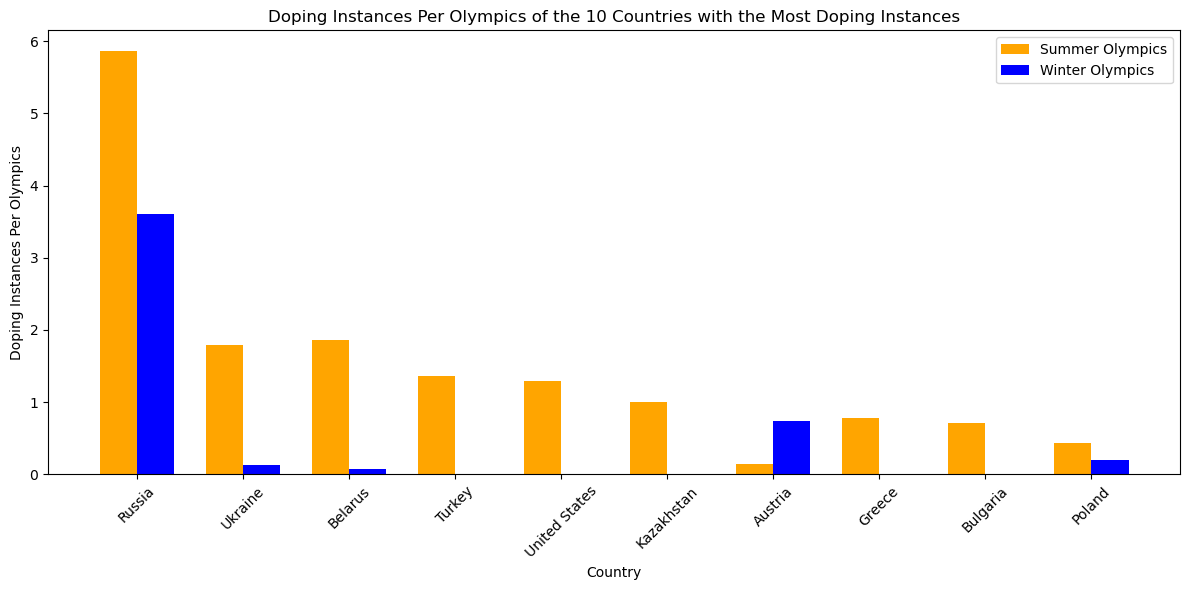

In [5]:
# Only show most notable data
top_ten_cheaters = country_dope_counts.head(10)
positions = np.arange(len(top_ten_cheaters))

# Doping Instances Per Olympics bar graph
bar_width = 0.35
plt.figure(figsize=(12, 6))
plt.bar(positions - bar_width/2, top_ten_cheaters['dopes_per_summer_olympics'], bar_width, color='orange', label='Summer Olympics')
plt.bar(positions + bar_width/2, top_ten_cheaters['dopes_per_winter_olympics'], bar_width, color='blue', label='Winter Olympics')
plt.xticks(positions, top_ten_cheaters['Country'], rotation=45)
plt.xlabel('Country')
plt.ylabel('Doping Instances Per Olympics')
plt.legend()
plt.title('Doping Instances Per Olympics of the 10 Countries with the Most Doping Instances')
plt.tight_layout()
plt.show()

Compare the average number of instances per country for summer and winter to see if there is a difference. Only use countries that compete in both.

Found a p-value of 0.0331 showing a statistically significant difference. We can conclude the average number of instances is not the same for summer vs winter. The t-statistic is 2.3322 showing the average in summer is greater than the average in winter.

In [6]:
# Since half the countries only participate in Summer Olympics, the t-test should only be run on data from countries that do both
both_season_dopers = country_dope_counts[(country_dope_counts['dopes_per_summer_olympics'] > 0) & (country_dope_counts['dopes_per_winter_olympics'] > 0)]
both_season_dopers = both_season_dopers.sort_values(by='dopes_per_olympics', ascending=False)

# Significant p-value found: Doping seems to occur more in Summer olympics vs Winter olympics
t_stat, p_value = ttest_rel(both_season_dopers['dopes_per_summer_olympics'], both_season_dopers['dopes_per_winter_olympics'])
print(f"{t_stat=}\n{p_value=}")

t_stat=2.332167829445411
p_value=0.033081230202732514


## Medals

Count the number of each medal for each country. Uses medals from 1896-2022.

In [7]:
# Same as first web scrape, but we are now getting data on medals per country
response_medals = requests.get('https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table')

if response_medals.status_code == 200:
    medal_soup = BeautifulSoup(response_medals.text)
    country_medals = {}

    main_medal_table = medal_soup.find_all('table', {'class': 'wikitable'})[12]
    medal_rows = main_medal_table.find_all('tr')
    for medal_row in medal_rows:
        medal_cells = medal_row.find_all(['td', 'th'])
        if medal_cells:
            country_cell_for_medals = medal_cells[1]
            country_hyperlink = country_cell_for_medals.find('a')
            if country_hyperlink:
                country_name_for_medals = country_hyperlink.get_text(strip=True)
                country_medals[country_name_for_medals] = {
                    'Gold': int(medal_cells[2].text),
                    'Silver': int(medal_cells[3].text),
                    'Bronze': int(medal_cells[4].text),
                    'Total': int(medal_cells[5].text)
                }
else:
    print("Failed to retrieve the webpage.")

In [8]:
# Merge doping data with medal data
country_medals_df = pd.DataFrame(country_medals).T.reset_index()
country_medals_df.columns = ['Country', 'Gold', 'Silver', 'Bronze', 'Total']
# country_medals_df

In [9]:
all_data = pd.merge(country_dope_counts, country_medals_df, on='Country', how='outer')
all_data['medals_per_doper'] = all_data['Total'] / all_data['times_caught_doping']
all_data = all_data.sort_values(by='medals_per_doper', ascending=False)
# all_data

### Countries with Medals and No Doping Instances

Some countries had no doping instances and earned medals.

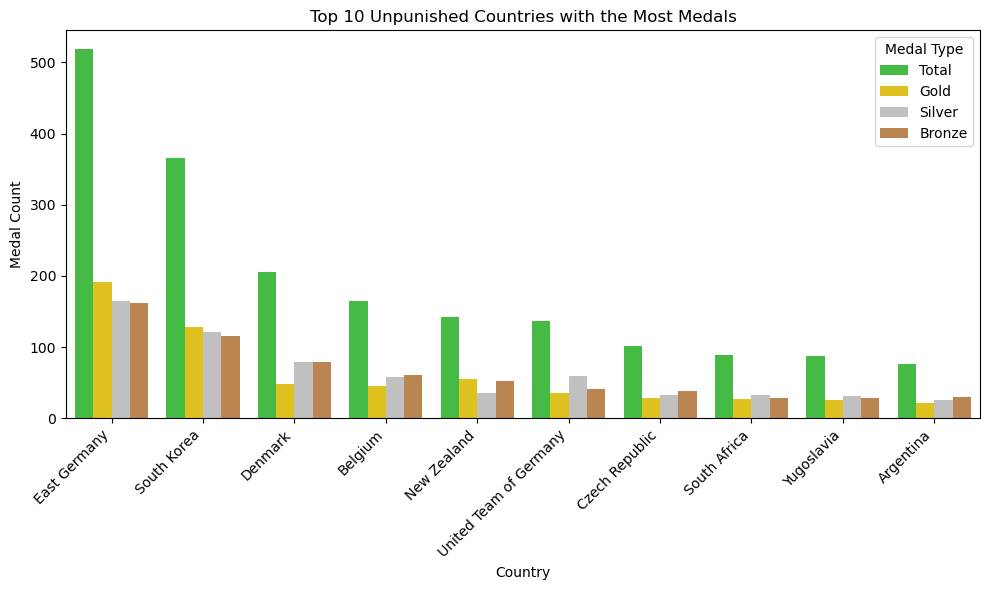

In [10]:
# Get data for countries with no recorded doping instances
zero_dope_countries = all_data[all_data['times_caught_doping'].isna()]

# Bar graph will have separate columns for each medal type
top_countries = zero_dope_countries.nlargest(10, 'Total')
columns_to_keep = ['Country', 'Total', 'Gold', 'Silver', 'Bronze']
top_countries_medals = top_countries[columns_to_keep]
melted_df = top_countries_medals.melt(id_vars='Country', var_name='Medal', value_name='Count')

# "Unpunished countries" bar chart
plt.figure(figsize=(10, 6))
medal_colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru', 'Total': 'limegreen'}
sns.barplot(x='Country', y='Count', hue='Medal', data=melted_df, palette=medal_colors)
plt.title('Top 10 Unpunished Countries with the Most Medals')
plt.xlabel('Country')
plt.ylabel('Medal Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Medal Type')
plt.show()

### Medals by Doping Instances

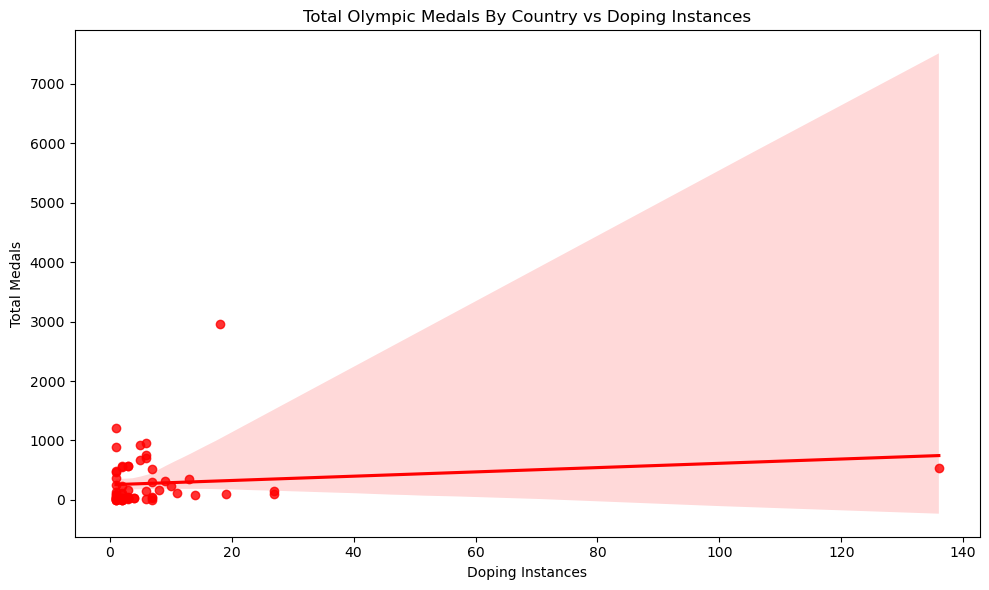

corr_coeff=0.1406144175982067
p_value=0.27167434653035943


In [11]:
# This gets rid of non-dopers and also gets rid of non-medalists
dope_countries = all_data.dropna()

# Medal Count v Dope Count scatterplot
plt.figure(figsize=(10, 6))
sns.regplot(x='times_caught_doping', y='Total', data=dope_countries, color="red")
plt.title('Total Olympic Medals By Country vs Doping Instances')
plt.xlabel('Doping Instances')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

# No significant relationship between medal count and doping count
corr_coeff, p_value = pearsonr(dope_countries['times_caught_doping'], dope_countries['Total'])
print(f"{corr_coeff=}\n{p_value=}")

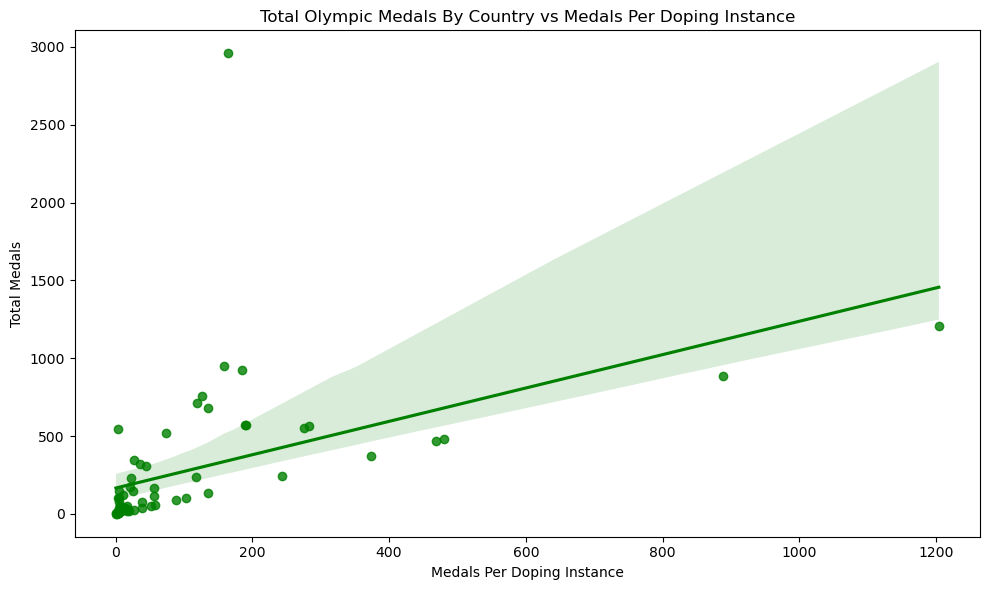

corr_coeff=0.49022572779622187
p_value=4.536164932754652e-05


In [12]:
# Medal Count v Medals per Doper scatterplot
plt.figure(figsize=(10, 6))
sns.regplot(x='medals_per_doper', y='Total', data=dope_countries, color="green")
plt.title('Total Olympic Medals By Country vs Medals Per Doping Instance')
plt.xlabel('Medals Per Doping Instance')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

# Significant relationship between medal count and medals per doper
corr_coeff, p_value = pearsonr(dope_countries['medals_per_doper'], dope_countries['Total'])
print(f"{corr_coeff=}\n{p_value=}")